In [95]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt

In [ ]:
from models.vae import VAE 
from models.controller import Controller
from torchsummary import summary

input_size = 32 + 13
output_size = 13

model = Controller(input_size, output_size).cuda()
summary(model, (1, input_size))

In [ ]:
pc0 = 0.0910
pc1 = 0.1467
b = 0.6
c = 0.3

pc = ((pc0*pc1)**b) * (((pc1-pc0)/pc1)**c) 
ic = 0.0697

print(f'{100.0 + ic/pc}, {pc}')

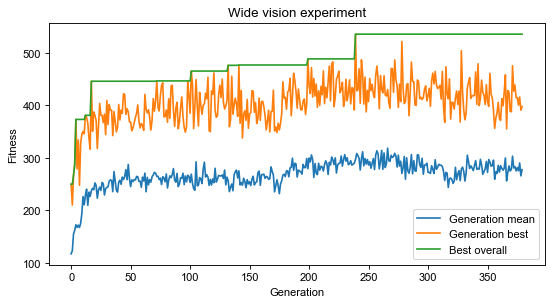

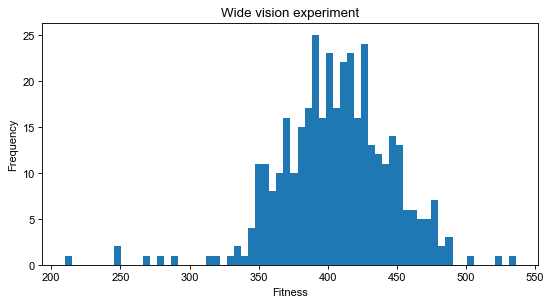

In [124]:
env_name = '20200817_223101'
results_folder = 'results'
optimizer = 'cma'
num_rollouts = 1
popsize = 32

filename = os.path.join(results_folder, env_name, 'fitness.txt')

with open(filename, 'r') as f:
  data = np.loadtxt(f, delimiter='/', skiprows=1)

plt.rcParams["font.family"] = "Arial"
fig = plt.figure(figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')

line_mean, = plt.plot(data[:, 0], data[:, 1])
line_best_gen, = plt.plot(data[:, 0], data[:, 2])
line_best_overall, = plt.plot(data[:, 0], data[:, 3])
plt.legend([line_mean, line_best_gen, line_best_overall], ['Generation mean', 'Generation best', 'Best overall'], loc=4)

plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Wide vision experiment')
plt.savefig(filename + ".svg")

fig = plt.figure(figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')
plt.title('Wide vision experiment')
plt.savefig(filename + ".svg")

plt.hist(data[:, 2], density=False, bins=64) 
plt.ylabel('Frequency')
plt.xlabel('Fitness');

plt.show()